## Clean Posts for EDA

In [78]:
import pandas as pd
import missingno as msno

___
## Read in Post CSV

- Read in CSV and create dataframe; low_memory = False to work around an error/warning that was being thrown that there were mutliple datatypes per column.
<br>
- low_memory loads all the columns first, only after all columns are loaded does it determine data types.

In [79]:
df_posts = pd.read_csv('../data/NVIDIA_AMD.csv', low_memory=False, index_col=0)

In [80]:
df_posts.head()

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,saved,selftext_html,ups,user_reports,brand_safe,approved_at_utc,banned_at_utc,from_kind,from_id,from
0,nvidia,[removed],t2_7ryvc7f3e,0.0,Need advice about 4090,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nvidia,Which should I use and are they both safe? [Pr...,t2_s6iy0sui,0.0,NvidiaProfileInspector or NvidiaInspector?,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nvidia,before march fifth my vids looked like this \n...,t2_7yc3wcn9,0.0,shadowplay is wierdpease help me,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nvidia,NaN,t2_3gkjrjff,0.0,New CableMod cable came in! Does the 16pin ada...,"[{'e': 'text', 't': 'Discussion'}]",r/nvidia,False,6.0,discussion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nvidia,CPU: Intel Core i7-8700 3.20GHz\nRAM: 16GB\nGP...,t2_tjzwh4fi,0.0,Nvidia Gefore GTX 1060 6gb replacement options?,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


___

## Null Population

<AxesSubplot:>

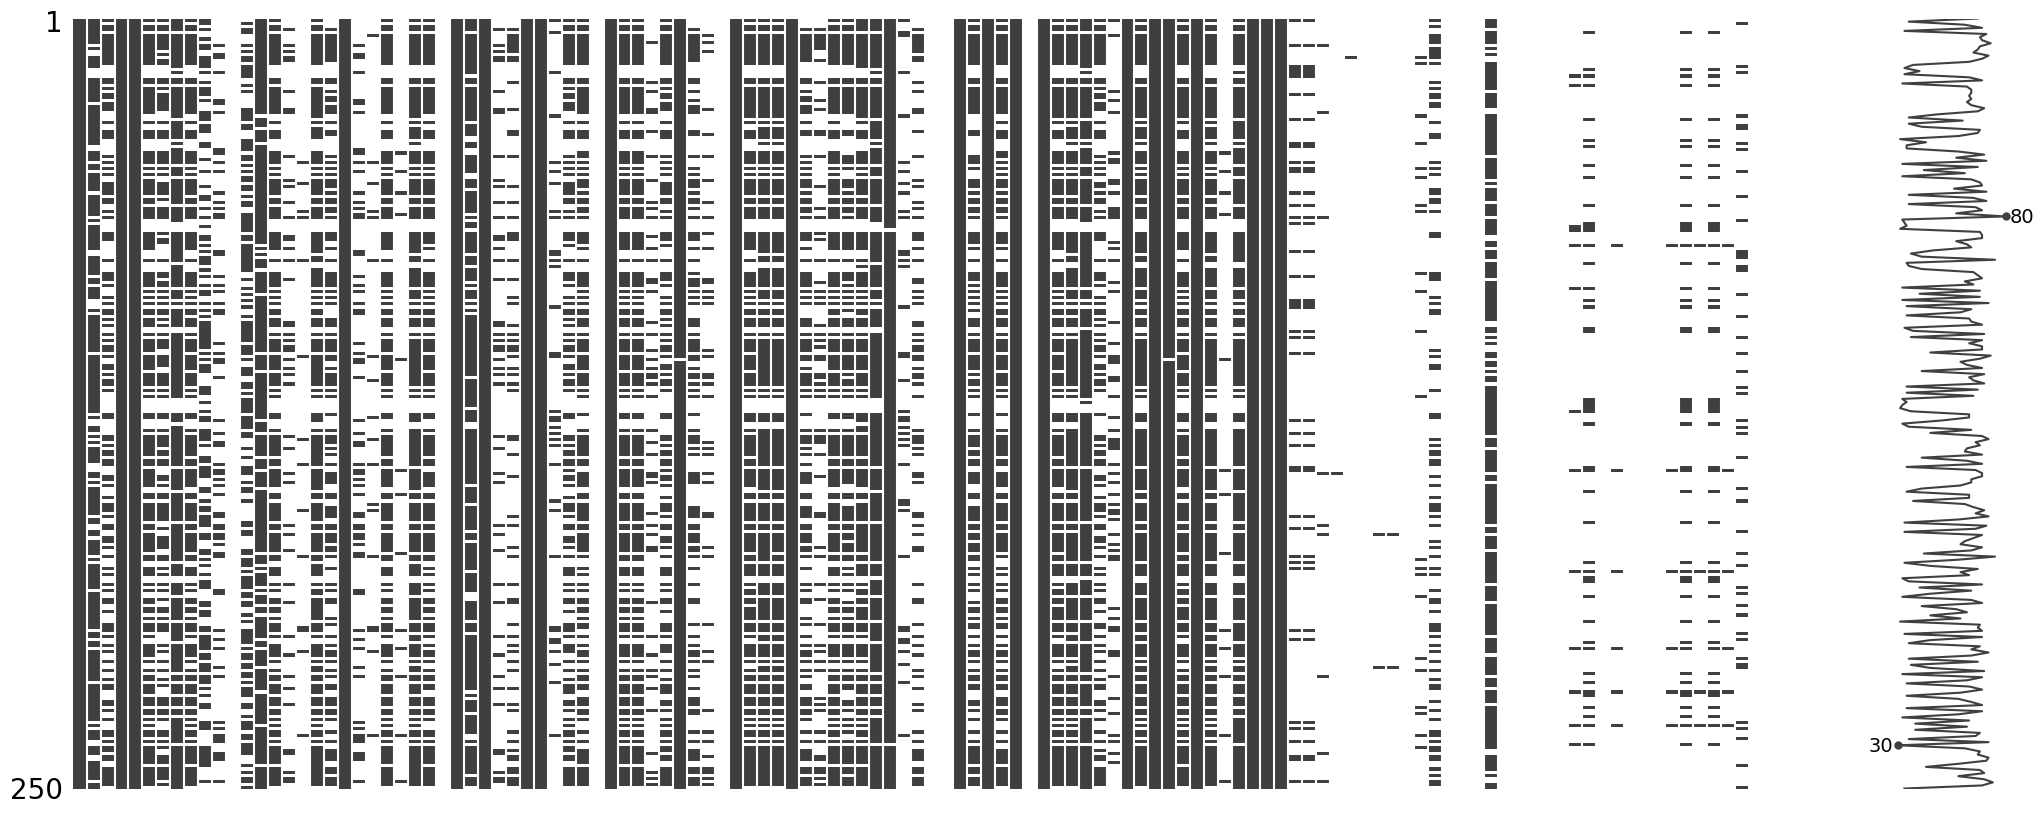

In [81]:
%matplotlib inline
msno.matrix(df_posts.sample(250))

- I really enjoy using the missingno library to get a visual snapshot of the data you pull in. 
- From the above there are definitely multiple columns, at least half, that are full nulls. 
- Seeing as we are only going to be using the title,body of the posts/submissions to determine what subreddit a post is from this null population won't be too hard to reduce, but I am curious how many out of the ~408k submissions will actually be usable. 

___ 
### Pushshift Data Dictionary and usable post analysis
- I was able to find a data dictionary to help describe the different parameters and types of each returned field for submissions endpoint (and comments). But not the value types, for example quarantine only has "False" and "NaN", there is no "True"

https://www.reddit.com/r/pushshift/comments/8h31ei/documentation_pushshift_api_v40_partial/

In [82]:
df_posts['quarantine'].value_counts()

False    364387
Name: quarantine, dtype: int64

In [83]:
df_posts['quarantine'].isnull().sum()

44555

In an effort to find any posts that were removed or quarantined, I had assumed when quarantined was NaN it meant True. I double checked the removed_by column as a sign that a post was removed, but only 2 out of the entire dataset (~400k observations) were removed listed as removed by a user.
- I am going to check for selftext's null count first to see the most important null count before deciding to remove any others
- After removing where selftext is null, recheck the quarantine and removed_by counts to see if they were included in the population.

In [84]:
df_posts['removed_by'].value_counts()

t5_2rlgy    2
Name: removed_by, dtype: int64

In [85]:
df_posts.loc[df_posts['quarantine']!=None, ['removed_by']].value_counts()

removed_by
t5_2rlgy      2
dtype: int64

___
### SelfText Null Filter
- 94,299 submissions have no body/selftext. That is 23% of total observations in this data set. I think I have an enormous dataset and going from ~400k to ~310k, while a large loss, it still seems like enough data.

In [86]:
(df_posts['selftext'].isnull().sum()/len(df_posts['selftext']))*100

23.05926023739308

In [87]:
df_posts = df_posts[df_posts['selftext'].isnull()==False]

In [88]:
df_posts.shape

(314643, 125)

In [89]:
df_posts['subreddit'].value_counts()

Amd              187895
nvidia           126745
u_Team-Nvidia         1
Name: subreddit, dtype: int64

In [90]:
df_posts = df_posts[df_posts['subreddit']!='u_Team-Nvidia']

___
### Selftext == '[removed]'
- Another sharp cut to the total number of observations, when checking for selftext that has been removed, there remains only ~196k observations from the original dataset
- Further more there is a bit of a population difference between the two subreddits, nvidia with 75,877 observations, amd with 120094
- I have to remove the 118,669 rows that have no selftext as they won't help me classify. I will remove these observations and move forward with the above split. If down the line I think I need more data I will repull new sets from an earlier data (current data set is from present day to January 1st, 2015)

In [91]:
df_posts[(df_posts['selftext']!='[removed]') & (df_posts['subreddit']=='nvidia')]

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,saved,selftext_html,ups,user_reports,brand_safe,approved_at_utc,banned_at_utc,from_kind,from_id,from
1,nvidia,Which should I use and are they both safe? [Pr...,t2_s6iy0sui,0.0,NvidiaProfileInspector or NvidiaInspector?,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nvidia,before march fifth my vids looked like this \n...,t2_7yc3wcn9,0.0,shadowplay is wierdpease help me,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nvidia,CPU: Intel Core i7-8700 3.20GHz\nRAM: 16GB\nGP...,t2_tjzwh4fi,0.0,Nvidia Gefore GTX 1060 6gb replacement options?,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,nvidia,I have an MSI Venus 2X RTX 3060 Card and I've ...,t2_2vvw9l7e,0.0,Did latest driver update break features like R...,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,nvidia,Hi \n\nI built my PC last May and no problem s...,t2_9ea5otcg,0.0,Msi Suprim 3080 ti downclock itself by 250mhz ...,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157732,nvidia,"so my last post was not quite detailed, so her...",NaN,0.0,NVIDIA GEFORCE GTX 980 HELP!,NaN,NaN,NaN,NaN,NaN,...,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157733,nvidia,I want to see what it is doing.,NaN,0.0,Can I graph my GPU usage while I game?,NaN,NaN,NaN,NaN,NaN,...,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157734,nvidia,"I'm running a GTX 660 on the latest drivers, i...",NaN,0.0,Turn Shadowplay on/off with hotkey?,NaN,NaN,NaN,NaN,NaN,...,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157735,nvidia,http://i.imgur.com/dkgvqpF.jpg\ngtx 770 classi...,NaN,0.0,mosfet locations on my cards?,NaN,NaN,NaN,NaN,NaN,...,False,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df_posts[(df_posts['selftext']!='[removed]') & (df_posts['subreddit']=='Amd')]

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,saved,selftext_html,ups,user_reports,brand_safe,approved_at_utc,banned_at_utc,from_kind,from_id,from
157740,Amd,"Hi guys, \nI'm still deciding should I go for...",t2_7rhxyk2h,0.0,New 12 month warranty 6700 XT Red Devil 440$ o...,[],r/Amd,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157746,Amd,I bought a 6800xt red devil around 7 months ag...,t2_ybyi2,0.0,Always check your overclocks,[],r/Amd,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157750,Amd,6800xt Red Devil was acting a little hot for ...,t2_2olrd8oh,0.0,Can't seem to reduce 6800xt temps,[],r/Amd,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157754,Amd,I’m midst of building a PC that’s going to las...,t2_833qf,0.0,AMD 6&amp;7 series cards - Sea of Thieves,[],r/Amd,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157760,Amd,I have the exact same BIOS settings as before ...,t2_6y9rt5em,0.0,AMD Ryzen 3700x Core Voltage problem,[],r/Amd,False,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408905,Amd,With the price of the HD7950s going for about ...,NaN,0.0,HD7950 or R9 270X,NaN,NaN,NaN,NaN,NaN,...,NaN,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",4.0,[],NaN,NaN,NaN,NaN,NaN,NaN
408915,Amd,"With the new anouncements made by AMD, would i...",NaN,0.0,AMD+Mantle vs Intel,NaN,NaN,NaN,NaN,NaN,...,NaN,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",5.0,[],NaN,NaN,NaN,NaN,NaN,NaN
408920,Amd,These are my two options. I cant get another C...,NaN,0.0,AMD FX 4350 vs AMD FX 6300 for gaming?,NaN,NaN,NaN,NaN,NaN,...,NaN,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",3.0,[],NaN,NaN,NaN,NaN,NaN,NaN
408925,Amd,"04:30PM EDT - Available on R9 290X, R9 290 and...",NaN,0.0,True Audio and R9 280X/R9 270X cards,NaN,NaN,NaN,NaN,NaN,...,NaN,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",2.0,[],NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
df_posts[df_posts['selftext']=='[removed]']

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,saved,selftext_html,ups,user_reports,brand_safe,approved_at_utc,banned_at_utc,from_kind,from_id,from
0,nvidia,[removed],t2_7ryvc7f3e,0.0,Need advice about 4090,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,nvidia,[removed],t2_diil9yih,0.0,Inno3d X3 OC 4090 enjoyers?,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,nvidia,[removed],t2_b1s89j9i,0.0,GPU NOT DETECTED ON PC,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,nvidia,[removed],t2_b07quydg,0.0,monitor refreshrate oc not working with the la...,"[{'e': 'text', 't': 'Question'}]",r/nvidia,False,6.0,question,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,nvidia,[removed],t2_hu4bxnpy,0.0,16GB VRAM is like the NEW System 16GB standard...,"[{'e': 'text', 't': 'Discussion'}]",r/nvidia,False,6.0,discussion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408170,Amd,[removed],NaN,0.0,Powercolor shitty rma support,NaN,NaN,NaN,NaN,NaN,...,False,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408207,Amd,[removed],NaN,0.0,Problems with amd mobile drivers,NaN,NaN,NaN,NaN,NaN,...,False,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408235,Amd,[removed],NaN,0.0,"Sapphire 390, been getting ""displayport link f...",NaN,NaN,NaN,NaN,NaN,...,False,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408274,Amd,[removed],NaN,0.0,Sad day for a Fury X CF.,NaN,NaN,NaN,NaN,gpu,...,False,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_posts = df_posts[df_posts['selftext']!='[removed]']

In [95]:
df_posts.shape

(195973, 125)

___
### Column/Feature reduction
- For classification I only need subreddit as target and selftext and title as training data, but I am going to keep author and num_comments for some EDA purposes

In [96]:
df_posts = df_posts.loc[:,['subreddit','selftext','title','author','num_comments']]

In [97]:
df_posts.head()

,subreddit,selftext,title,author,num_comments
1,nvidia,Which should I use and are they both safe? [Pr...,NvidiaProfileInspector or NvidiaInspector?,DeepSpaceHorizon,0.0
2,nvidia,before march fifth my vids looked like this \n...,shadowplay is wierdpease help me,bob6572,0.0
4,nvidia,CPU: Intel Core i7-8700 3.20GHz\nRAM: 16GB\nGP...,Nvidia Gefore GTX 1060 6gb replacement options?,shukii89,0.0
5,nvidia,I have an MSI Venus 2X RTX 3060 Card and I've ...,Did latest driver update break features like R...,cr6sxwastaken,0.0
6,nvidia,Hi \n\nI built my PC last May and no problem s...,Msi Suprim 3080 ti downclock itself by 250mhz ...,Kooky-Introduction70,0.0


In [98]:
df_posts.shape

(195973, 5)

- One last null check before saving..

In [99]:
df_posts.isnull().sum()

subreddit       2
selftext        0
title           4
author          2
num_comments    4
dtype: int64

- Drop the rest null values losing only 4 additional observations

In [100]:
df_posts.dropna(inplace=True)

In [101]:
df_posts.shape

(195969, 5)

___
### Save Null Cleaned as new csv for EDA

In [102]:
df_posts.to_csv('../data/cleaned_NVIDIA_AMD.csv')